In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.api import AutoReg
import pickle
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

import sys
sys.path.insert(0, "../Src/")
import loadData

%autosave 5

Autosaving every 5 seconds


Autosaving every 5 seconds


In [2]:
def determineDifferenceOrder(data):
    p = 100
    order = 0
    while p > 0.05:
        acf = plot_acf(data,title=f'acf diff order = {order}')
        pacf = plot_pacf(data, title=f'pacf diff order = {order}')
        adfTest = adfuller(data)
        p = adfTest[1]
        print(f'p: {adfTest[1]}')
        if p > 0.05:
            order += 1
            data = data.diff().dropna()
    return order

In [3]:
def trainArima(data):
    print('Training ARIMA')
    d = determineDifferenceOrder(data)
    possibleP = np.arange(d+1)
    possibleQ = np.arange(d+1)
    
    arrayData = np.asarray(data['Close'])
    trainDevCutOff = int(len(arrayData) * 0.8)
    train = arrayData[:trainDevCutOff]
    dev = arrayData[trainDevCutOff:]
    
    bestArima = None
    bestMAE = np.inf
    bestP = 0
    bestQ = 0

    for _ in range(10):
        p = np.random.choice(possibleP)
        q = np.random.choice(possibleQ)
        arima = ARIMA(train,order =(p,d,q))
        arimaFit = arima.fit()
        forecast = arimaFit.forecast(len(dev))
        mae = mean_absolute_error(dev, forecast)
        if mae < bestMAE:
            bestMae = mae
            bestP = p
            bestQ = q

    arima = ARIMA(train,order =(bestP,d,bestQ))
    arimaFit = arima.fit()
    print(arimaFit.summary())
    residuals = arimaFit.resid[1:]

    fig,ax = plt.subplots(1,2)
    residuals.plot(title = 'Residuals', ax = ax[0])
    residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])

    saveModel(arimaFit,'arima')
    return arimaFit

In [4]:
def saveModel(model,name):
    filename = f'../Models/{name}.pkl'
    if name in ['autoRegression','sarima','ExponentialSmoothing']:
        with open(filename, 'wb') as pkl:
            pickle.dump(model, pkl)
    else:
        model.save(filename)

In [5]:
def trainSarima(train):
    print('Training Sarima')
    sarima = pm.auto_arima(train,stepwise=True,seasonal=True)
    print(sarima.summary())
    saveModel(sarima,'sarima')
    return sarima

In [6]:
def trainAutoRegression(data):
    print('Training AutoRegression')
    bestLag = 0
    bestCorr = 0
    for lag in range(1,11):
        corr = data['Close'].corr(data['Close'].shift(lag))
        if corr > bestCorr:
            bestLag = lag
            bestCorr = corr
    print(f'AR order = {bestLag}')
    ar_model = AutoReg(data, lags=bestLag)
    ar_model.fit()
    saveModel(ar_model,'autoRegression')
    return ar_model
    

In [7]:
def trainExponentialSmoothing(data):
    print('Training ExponentialSmoothing')
    arrayData = np.asarray(data['Close'])
    trainDevCutOff = int(len(arrayData) * 0.8)
    train = arrayData[:trainDevCutOff]
    dev = arrayData[trainDevCutOff:]

    possibleModels = [SimpleExpSmoothing, Holt, ExponentialSmoothing]
    possibleModelNames = ["SimpleExpSmoothing", "Holt", "ExponentialSmoothing"]
    bestMAE = np.inf

    bestModelIndex = 0
    bestSmoothingLevel = 0
    for _ in range(20):
        smoothingLevel = np.random.uniform(0.1, 0.9)
        modelIndex = np.random.choice(len(possibleModels))
        modelConstructor = possibleModels[modelIndex]
        model = modelConstructor(train)
        model_fit = model.fit(smoothing_level=smoothingLevel)
        forecast = model_fit.forecast(len(dev))
        mae = mean_absolute_error(dev, forecast)
        if mae < bestMAE:
            bestMAE = mae
            bestModelIndex = modelIndex
            bestSmoothingLevel = smoothingLevel
            
    print(f'model chosen {possibleModelNames[bestModelIndex]}')
    print(f'smoothing parameter {bestSmoothingLevel}')
    finalModelConstructor = possibleModels[bestModelIndex]
    final_model = finalModelConstructor(arrayData)
    final_model_fit = final_model.fit(smoothing_level=bestSmoothingLevel)
    
    saveModel(final_model_fit, 'ExponentialSmoothing')
    return model
    

In [8]:
def main():
    train, test = loadData.loadData('MSFT')
    trainAutoRegression(train)
    trainArima(train)
    trainSarima(train)
    trainExponentialSmoothing(train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training AutoRegression
AR order = 1
Training ARIMA
p: 0.8724888850412795
p: 1.2499416193356876e-18
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1047
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3128.418
Date:                Sun, 27 Oct 2024   AIC                           6260.836
Time:                        17:54:35   BIC                           6270.741
Sample:                             0   HQIC                          6264.592
                               - 1047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1019      0.024     -4.170      0.000      -0.150      -0.054
sigma2        23.1916      0.81

/Users/garysimmons/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/garysimmons/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/garysimmons/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/garysimmons/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/garysimmons/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:213: Es

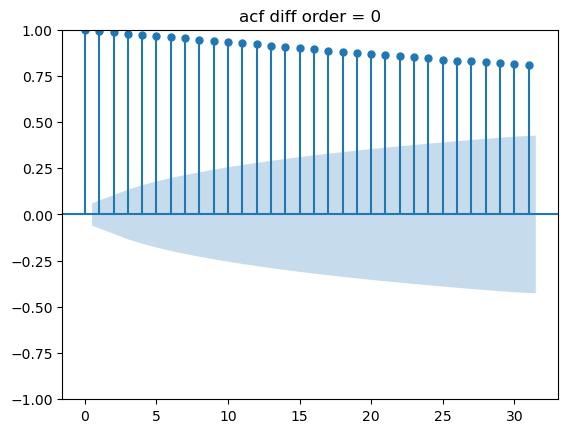

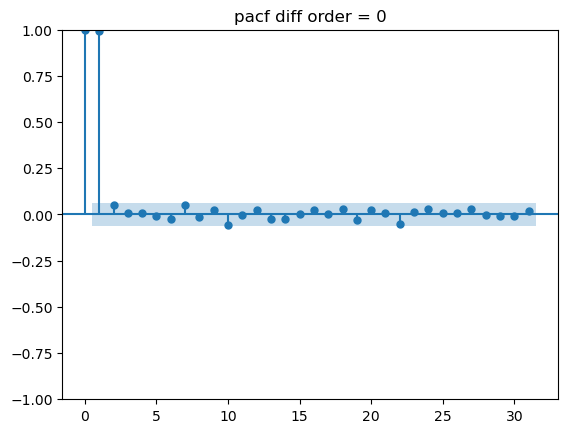

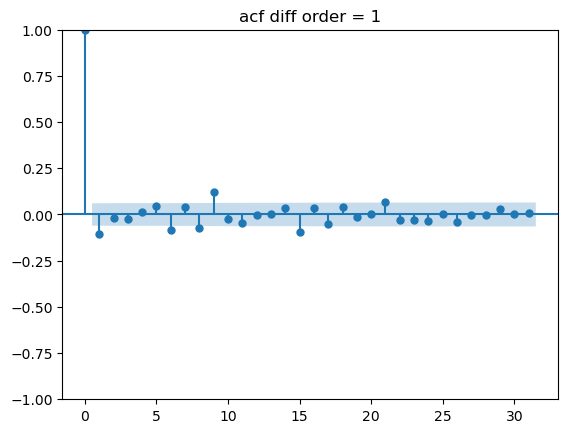

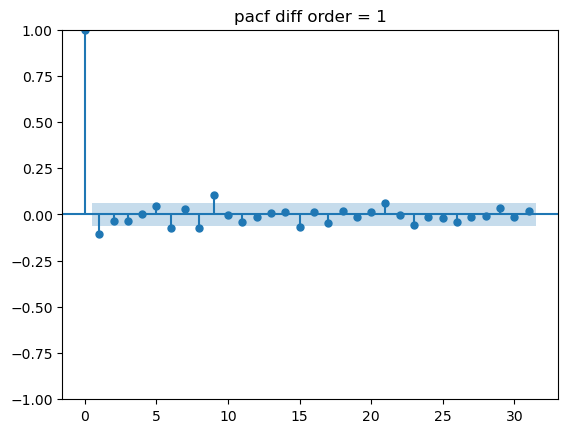

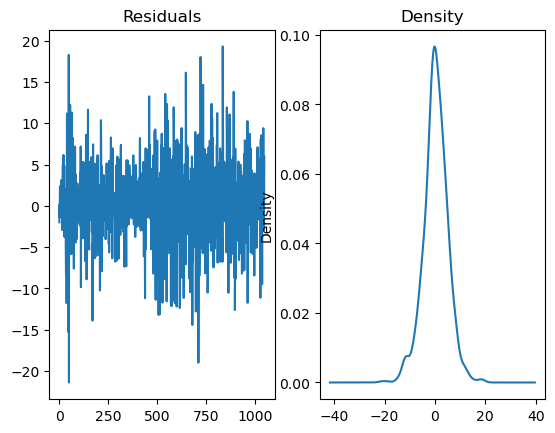

In [9]:
main()